# **Analisi e Modellazione dei Dati Stroke Prediction**

# **Obiettivo**
L'obiettivo di questo progetto è analizzare e modellare i dati relativi agli ictus cerebrali, cercando di prevedere la probabilità che un paziente possa avere un ictus sulla base delle sue caratteristiche personali e cliniche.


## **1. Installazione e Importazione delle Librerie**



In [ ]:
!pip install xgboost imbalanced-learn > /dev/null

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split, cross_val_score, KFold, cross_validate
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier


from imblearn.over_sampling import SMOTE

# Impostazioni grafiche
sns.set(style="darkgrid", palette="deep", font_scale=1.2)
plt.rcParams["figure.figsize"] = (7, 5)

## **2. Caricamento Dataset**

In [ ]:
# Percorso del dataset
file_path = "/content/healthcare-dataset-stroke-data.csv"


stroke_df = pd.read_csv(file_path)
print("Dataset caricato correttamente!\n")

# Alcune righe iniziali per visualizzare i dati
display(stroke_df.head())

Dataset caricato correttamente!



,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


## **3. Esplorazione Iniziale dei Dati**

### **3.1 Mappa dei Valori Mancanti**

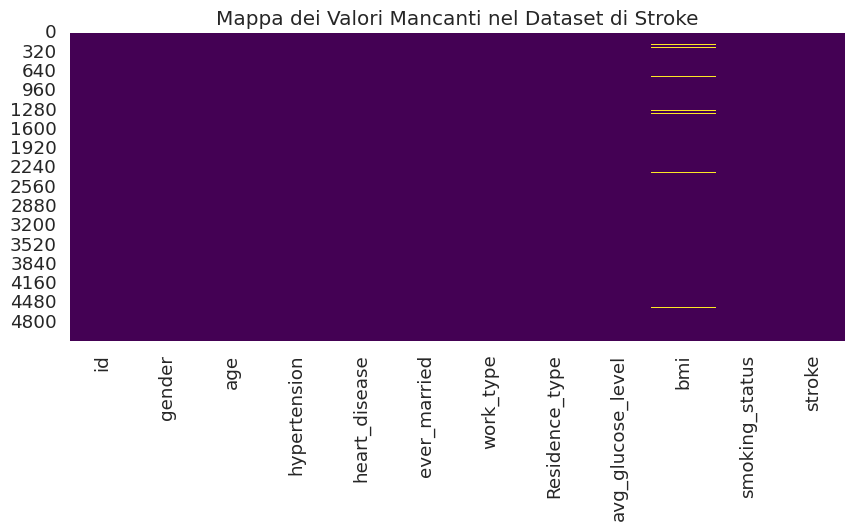

In [ ]:
plt.figure(figsize=(10,4))
sns.heatmap(stroke_df.isnull(), cbar=False, cmap="viridis")
plt.title("Mappa dei Valori Mancanti nel Dataset di Stroke")
plt.show()

### **3.2 Distribuzione della Variabile Target (stroke):**

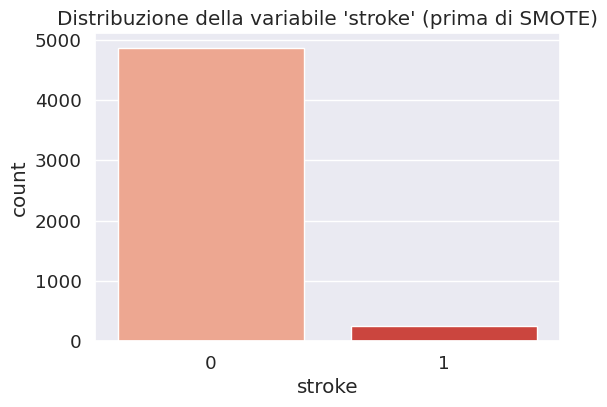

In [ ]:
plt.figure(figsize=(6,4))
sns.countplot(x='stroke', data=stroke_df, palette="Reds")
plt.title("Distribuzione della variabile 'stroke' (prima di SMOTE)")
plt.show()

### **3.3 Istogrammi (Variabili Numeriche):**

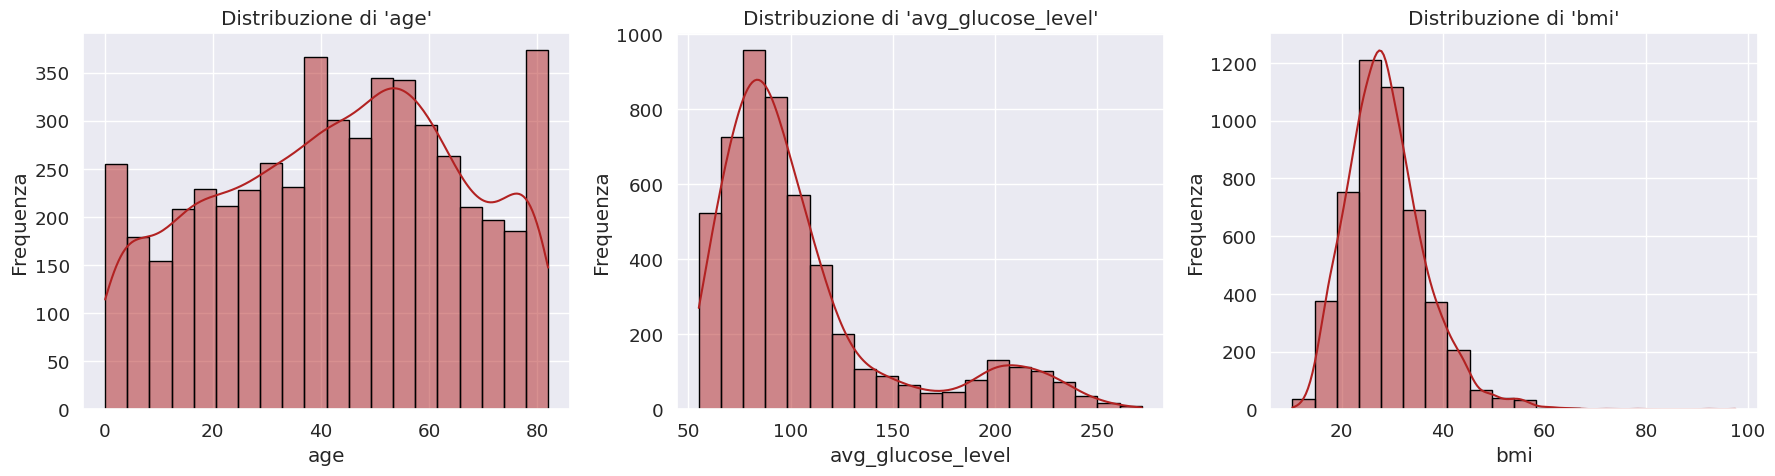

In [ ]:
numeric_cols = ['age', 'avg_glucose_level', 'bmi']
num_plots = len(numeric_cols)

# Creiamo una griglia di subplot (es. 1 riga, 3 colonne)
fig, axes = plt.subplots(1, num_plots, figsize=(18, 5))

for i, col in enumerate(numeric_cols):
    sns.histplot(stroke_df[col].dropna(), bins=20, color='firebrick', edgecolor='black', kde=True, ax=axes[i])
    axes[i].set_title(f"Distribuzione di '{col}'")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequenza')

plt.tight_layout()  # Migliora la spaziatura
plt.show()


### **3.4 Grafici (Variabili Categoriche):**

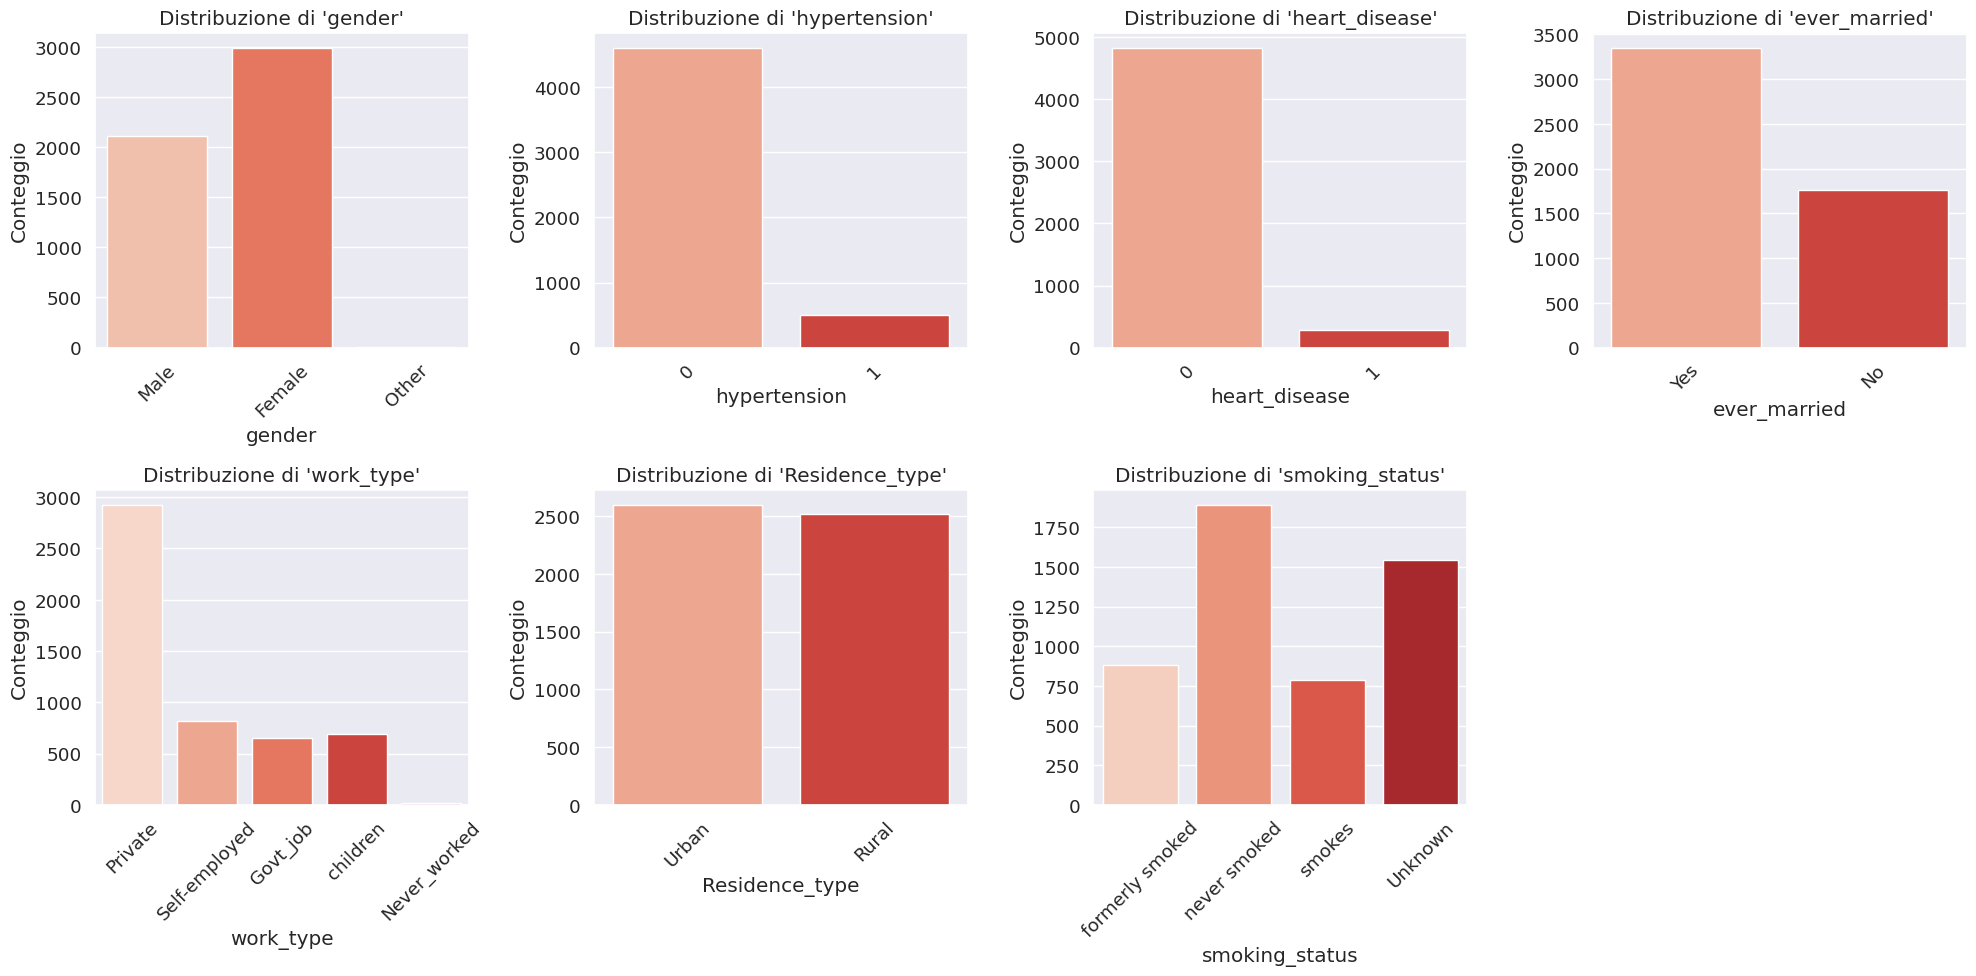

In [ ]:
categorical_cols = ['gender', 'hypertension', 'heart_disease', 'ever_married',
                    'work_type', 'Residence_type', 'smoking_status']
num_plots = len(categorical_cols)

# Definiamo il numero di righe e colonne della griglia
rows, cols = (2, 4)  # 2 righe, 4 colonne

fig, axes = plt.subplots(rows, cols, figsize=(20, 10))

# Flatten dell'array di assi per iterare facilmente
axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    sns.countplot(x=col, data=stroke_df, palette="Reds", ax=axes[i])
    axes[i].set_title(f"Distribuzione di '{col}'")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Conteggio')
    axes[i].tick_params(axis='x', rotation=45)

# Nasconde eventuali subplot vuoti
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


## **4. Pre-Elaborazione dei Dati**

In [ ]:
def preprocess_data(df):
    """
    - Imputa i valori mancanti:
        * Numeriche -> mediana
        * Categorical -> moda
    - Rimuove eventuali colonne inutili (es. 'id')
    - Assicura che la colonna 'stroke' sia binaria (0/1)
    """
    df = df.copy()

    # Rimuovo la colonna 'id
    if 'id' in df.columns:
        df.drop(columns=['id'], inplace=True)

    # Definisce le colonne numeriche e categoriche
    numeric_cols = ['age', 'avg_glucose_level', 'bmi']

    categorical_cols = ['gender', 'hypertension', 'heart_disease', 'ever_married',
                        'work_type', 'Residence_type', 'smoking_status', 'stroke']

    # Imputazione delle variabili numeriche con la mediana
    for col in numeric_cols:
        df[col] = df[col].fillna(df[col].median())

    # Imputazione delle variabili categoriche con la moda
    for col in categorical_cols:
        df[col] = df[col].fillna(df[col].mode()[0])

    return df

# Applichiamo la funzione di preprocessing
stroke_clean = preprocess_data(stroke_df)

print("Pre-elaborazione completata!\nValori null rimasti per colonna:")
print(stroke_clean.isnull().sum())

Pre-elaborazione completata!
Valori null rimasti per colonna:
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64


## **5. Feature Engineering (Encoding):**

In [ ]:
def feature_engineering(df):
    """
    Esegue l'One-Hot Encoding delle feature categoriche (esclusa 'stroke').
    """
    df_fe = df.copy()
    cat_cols = df_fe.select_dtypes(include=['object', 'category']).columns
    # Esclude la colonna target 'stroke'
    cat_cols = [col for col in cat_cols if col != 'stroke']
    df_fe = pd.get_dummies(df_fe, columns=cat_cols, drop_first=True)
    return df_fe

stroke_fe = feature_engineering(stroke_clean)
print("Feature Engineering completato!")
print("Shape dopo encoding:", stroke_fe.shape)
display(stroke_fe.head())


Feature Engineering completato!
Shape dopo encoding: (5110, 17)


,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Male,gender_Other,ever_married_Yes,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,67.0,0,1,228.69,36.6,1,True,False,True,False,True,False,False,True,True,False,False
1,61.0,0,0,202.21,28.1,1,False,False,True,False,False,True,False,False,False,True,False
2,80.0,0,1,105.92,32.5,1,True,False,True,False,True,False,False,False,False,True,False
3,49.0,0,0,171.23,34.4,1,False,False,True,False,True,False,False,True,False,False,True
4,79.0,1,0,174.12,24.0,1,False,False,True,False,False,True,False,False,False,True,False


## **7. Separazione delle Feature/Label e suddivisione in Train e Test:**

In [ ]:
X = stroke_fe.drop(columns=['stroke'])
y = stroke_fe['stroke']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Suddivisione Train/Test completata!")
print("Dimensioni del Training Set:", X_train.shape)
print("Dimensioni del Test Set:", X_test.shape)


Suddivisione Train/Test completata!
Dimensioni del Training Set: (4088, 16)
Dimensioni del Test Set: (1022, 16)


## **8. Bilanciamento del Dataset con SMOTE:**

In [ ]:
sm = SMOTE(random_state=0)
X_train_bal, y_train_bal = sm.fit_resample(X_train, y_train)

print("Bilanciamento con SMOTE completato!")
print("Distribuzione classi nel training set dopo SMOTE:")
print(pd.Series(y_train_bal).value_counts())


Bilanciamento con SMOTE completato!
Distribuzione classi nel training set dopo SMOTE:
stroke
0    3889
1    3889
Name: count, dtype: int64


## **9. Definizione ed Esecuzione dei Modelli:**

In [ ]:
# Definizione dei modelli
models = {
    "Decision Tree": DecisionTreeClassifier(criterion='entropy', random_state=0),
    "Random Forest": RandomForestClassifier(criterion='entropy', random_state=0),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=0),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5),
    "XGBoost": XGBClassifier(n_estimators=50, eval_metric="logloss", random_state=0)
}

## **10. Valutazione dei Modelli sul Test Set**


=== Valutazione dei modelli individuali ===

--- Decision Tree ---
Accuracy:  0.892
Precision: 0.921
Recall:    0.892
F1 Score:  0.906



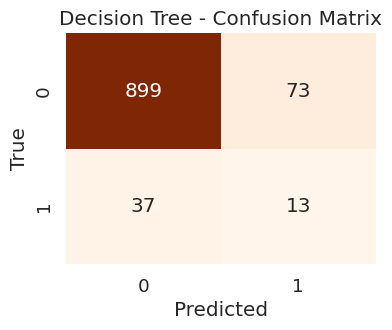

--- Random Forest ---
Accuracy:  0.920
Precision: 0.920
Recall:    0.920
F1 Score:  0.920



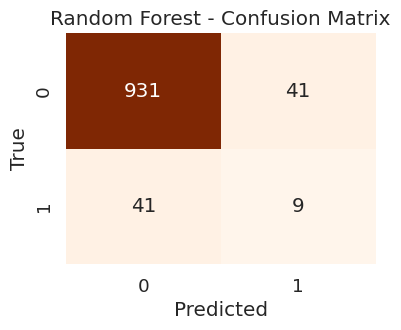

--- Logistic Regression ---
Accuracy:  0.846
Precision: 0.928
Recall:    0.846
F1 Score:  0.881



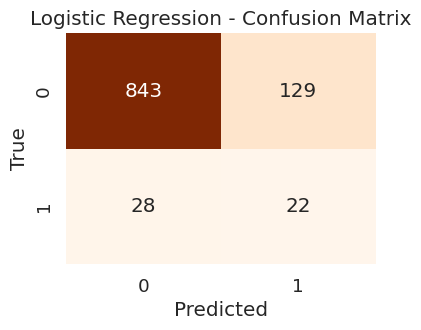

--- K-Nearest Neighbors ---
Accuracy:  0.822
Precision: 0.928
Recall:    0.822
F1 Score:  0.866



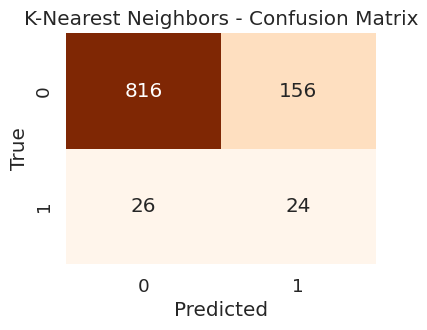

--- XGBoost ---
Accuracy:  0.919
Precision: 0.918
Recall:    0.919
F1 Score:  0.918



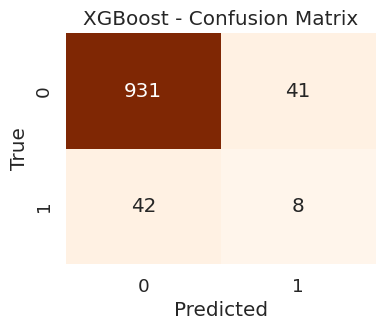

In [ ]:
predictions = {}
print("\n=== Valutazione dei modelli individuali ===\n")

for name, model in models.items():
    print(f"--- {name} ---")
    model.fit(X_train_bal, y_train_bal)
    y_pred = model.predict(X_test)

    # Calcola le metriche
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted')
    rec = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    print(f"Accuracy:  {acc:.3f}")
    print(f"Precision: {prec:.3f}")
    print(f"Recall:    {rec:.3f}")
    print(f"F1 Score:  {f1:.3f}\n")

    # Plot della Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', cbar=False)
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    # Salviamo le predizioni (servono per l'ensemble)
    predictions[name] = y_pred


## **11. Ensemble Majority Vote:**

Modelli selezionati per l'ensemble:
Random Forest: 0.920
XGBoost: 0.919
Decision Tree: 0.892

=== Ensemble Majority Vote Performance (Top 3 Modelli) ===
Accuracy:  0.925
Precision: 0.921
Recall:    0.925
F1 Score:  0.923


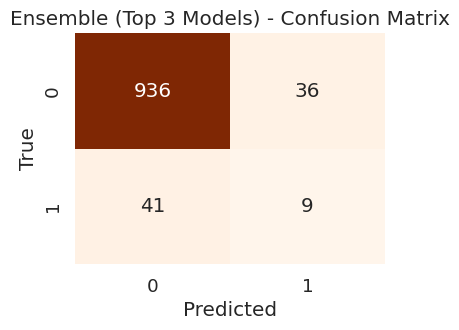

In [ ]:
def get_top_models(predictions_dict, y_true, n_top=3):
    """
    Seleziona i migliori n modelli basandosi sull'accuracy.
    """
    accuracies = {}
    for name, preds in predictions_dict.items():
        acc = accuracy_score(y_true, preds)
        accuracies[name] = acc

    top_models = dict(sorted(accuracies.items(), key=lambda x: x[1], reverse=True)[:n_top])
    top_predictions = {model: predictions_dict[model] for model in top_models.keys()}

    print("Modelli selezionati per l'ensemble:")
    for model, acc in top_models.items():
        print(f"{model}: {acc:.3f}")

    return top_predictions

def majority_vote(predictions_dict):
    """
    Combina le previsioni dei modelli tramite majority vote.
    """
    preds = np.array(list(predictions_dict.values()))
    majority_votes = []
    for i in range(preds.shape[1]):
        vote = np.bincount(preds[:, i])
        majority_votes.append(np.argmax(vote))
    return np.array(majority_votes)

# Selezioniamo i migliori 3 modelli e facciamo majority vote
top_predictions = get_top_models(predictions, y_test, n_top=3)
y_pred_ensemble = majority_vote(top_predictions)

# Calcoliamo le metriche dell'ensemble
ensemble_acc = accuracy_score(y_test, y_pred_ensemble)
ensemble_prec = precision_score(y_test, y_pred_ensemble, average='weighted')
ensemble_rec = recall_score(y_test, y_pred_ensemble, average='weighted')
ensemble_f1 = f1_score(y_test, y_pred_ensemble, average='weighted')

print("\n=== Ensemble Majority Vote Performance (Top 3 Modelli) ===")
print(f"Accuracy:  {ensemble_acc:.3f}")
print(f"Precision: {ensemble_prec:.3f}")
print(f"Recall:    {ensemble_rec:.3f}")
print(f"F1 Score:  {ensemble_f1:.3f}")

# Confusion Matrix dell'Ensemble
cm_ensemble = confusion_matrix(y_test, y_pred_ensemble)
plt.figure(figsize=(4, 3))
sns.heatmap(cm_ensemble, annot=True, fmt='d', cmap='Oranges', cbar=False)
plt.title("Ensemble (Top 3 Models) - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


## **12. Funzioni di Cross-Validation (per verificare overfitting) e Plot Risultati**


=== Esecuzione della Cross-Validation ===

Validazione del modello: Decision Tree

Risultati Decision Tree:
Test Accuracy: 0.926 (±0.007)
Test Precision: 0.927 (±0.007)
Test Recall: 0.926 (±0.007)
Test F1: 0.926 (±0.007)

Differenze Train-Test (possibile overfitting se > 0.1):
Accuracy Diff: 0.074
F1 Diff: 0.074

Validazione del modello: Random Forest

Risultati Random Forest:
Test Accuracy: 0.960 (±0.006)
Test Precision: 0.960 (±0.006)
Test Recall: 0.960 (±0.006)
Test F1: 0.960 (±0.006)

Differenze Train-Test (possibile overfitting se > 0.1):
Accuracy Diff: 0.040
F1 Diff: 0.040

Validazione del modello: Logistic Regression

Risultati Logistic Regression:
Test Accuracy: 0.874 (±0.004)
Test Precision: 0.875 (±0.004)
Test Recall: 0.874 (±0.004)
Test F1: 0.874 (±0.004)

Differenze Train-Test (possibile overfitting se > 0.1):
Accuracy Diff: 0.001
F1 Diff: 0.001

Validazione del modello: K-Nearest Neighbors

Risultati K-Nearest Neighbors:
Test Accuracy: 0.895 (±0.011)
Test Precision: 0.908

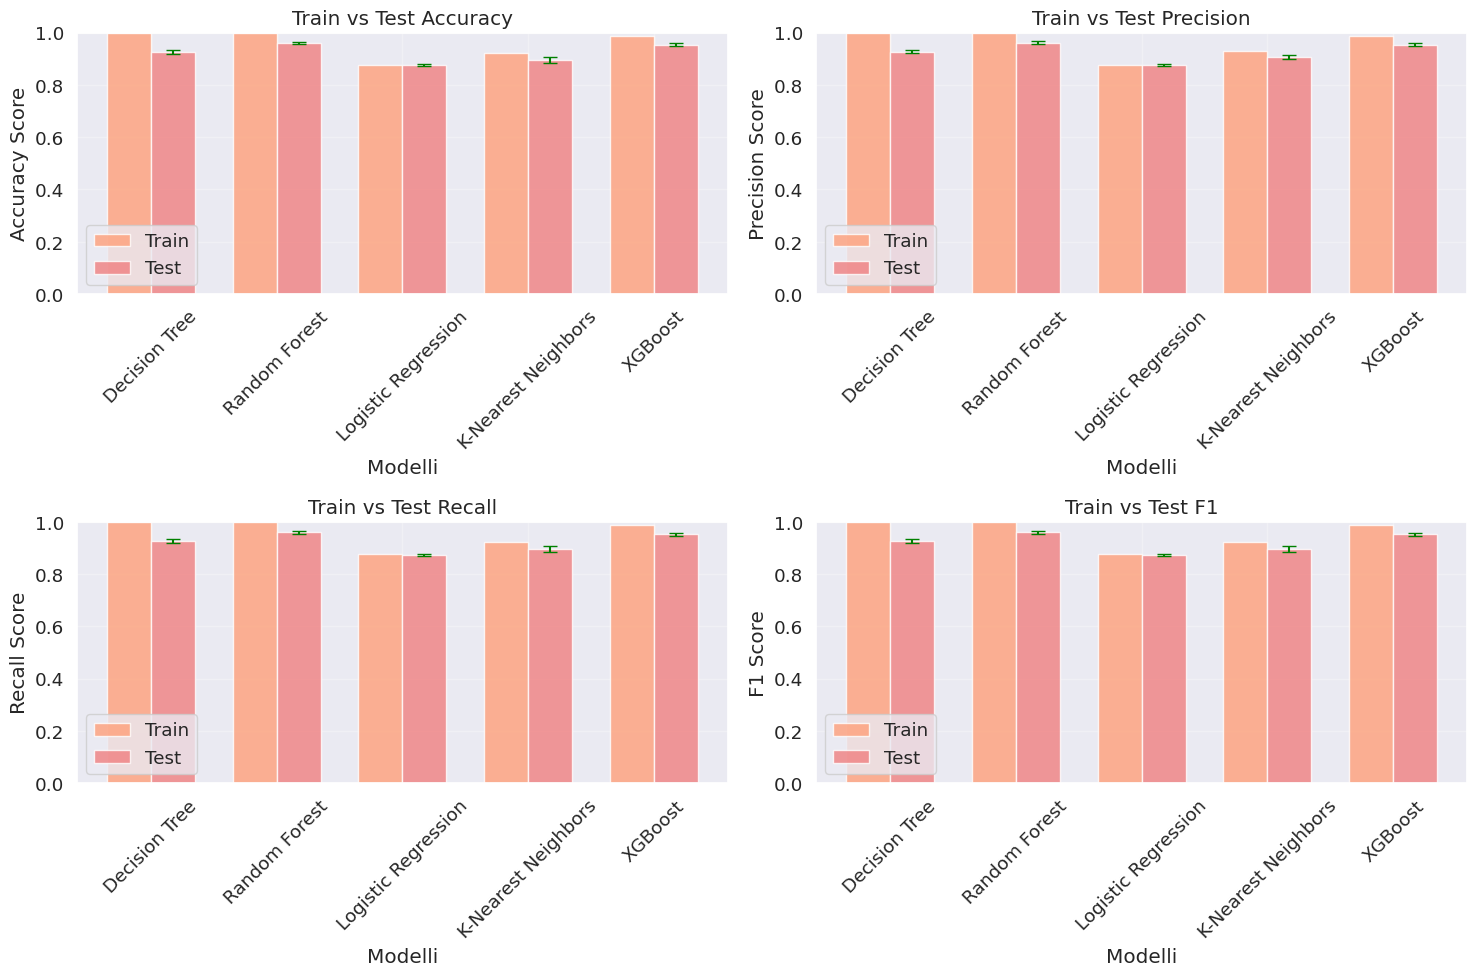

In [ ]:
def perform_cross_validation(models, X, y, n_splits=5):
    """
    Esegue cross-validation per ogni modello e calcola multiple metriche.
    """
    cv_results = {}
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    metrics = {
        'accuracy': 'accuracy',
        'precision': 'precision_weighted',
        'recall': 'recall_weighted',
        'f1': 'f1_weighted'
    }

    for name, model in models.items():
        print(f"\nValidazione del modello: {name}")

        # Esegue cross-validation con multiple metriche
        scores = cross_validate(model, X, y,
                                  scoring=metrics,
                                  cv=kf,
                                  return_train_score=True)

        # Calcola medie e deviazioni standard
        cv_results[name] = {
            'test_scores': {
                'accuracy': scores['test_accuracy'].mean(),
                'accuracy_std': scores['test_accuracy'].std(),
                'precision': scores['test_precision'].mean(),
                'precision_std': scores['test_precision'].std(),
                'recall': scores['test_recall'].mean(),
                'recall_std': scores['test_recall'].std(),
                'f1': scores['test_f1'].mean(),
                'f1_std': scores['test_f1'].std()
            },
            'train_scores': {
                'accuracy': scores['train_accuracy'].mean(),
                'precision': scores['train_precision'].mean(),
                'recall': scores['train_recall'].mean(),
                'f1': scores['train_f1'].mean()
            }
        }

        # Stampa i risultati per ogni modello
        print(f"\nRisultati {name}:")
        print(f"Test Accuracy: {scores['test_accuracy'].mean():.3f} (±{scores['test_accuracy'].std():.3f})")
        print(f"Test Precision: {scores['test_precision'].mean():.3f} (±{scores['test_precision'].std():.3f})")
        print(f"Test Recall: {scores['test_recall'].mean():.3f} (±{scores['test_recall'].std():.3f})")
        print(f"Test F1: {scores['test_f1'].mean():.3f} (±{scores['test_f1'].std():.3f})")

        # Differenza train-test per verificare overfitting
        print("\nDifferenze Train-Test (possibile overfitting se > 0.1):")
        print(f"Accuracy Diff: {scores['train_accuracy'].mean() - scores['test_accuracy'].mean():.3f}")
        print(f"F1 Diff: {scores['train_f1'].mean() - scores['test_f1'].mean():.3f}")

    return cv_results

def plot_cv_results(cv_results):
    """
    Visualizza i risultati della cross-validation
    """
    plt.figure(figsize=(15, 10))

    # Prepara i dati per il plot
    models_list = list(cv_results.keys())
    metrics = ['accuracy', 'precision', 'recall', 'f1']

    # Plot per ogni metrica
    for i, metric in enumerate(metrics, 1):
        plt.subplot(2, 2, i)

        test_scores = [cv_results[model]['test_scores'][metric] for model in models_list]
        test_stds = [cv_results[model]['test_scores'][f'{metric}_std'] for model in models_list]
        train_scores = [cv_results[model]['train_scores'][metric] for model in models_list]

        x = np.arange(len(models_list))
        width = 0.35

        plt.bar(x - width/2, train_scores, width, label='Train', color='lightsalmon', alpha=0.8)
        plt.bar(x + width/2, test_scores, width, label='Test', color='lightcoral', alpha=0.8)
        plt.errorbar(x + width/2, test_scores, yerr=test_stds, fmt='none', color='green', capsize=5)

        plt.xlabel('Modelli')
        plt.ylabel(f'{metric.capitalize()} Score')
        plt.title(f'Train vs Test {metric.capitalize()}')
        plt.xticks(x, models_list, rotation=45)
        plt.ylim(0, 1)
        plt.legend()
        plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Esecuzione della cross-validation sui dati bilanciati
print("\n=== Esecuzione della Cross-Validation ===")
cv_results = perform_cross_validation(models, X_train_bal, y_train_bal)
plot_cv_results(cv_results)